In [11]:
###This code generates autoencoders for quantum phase transtions. Circuits were taken from arXiv:1905.10876 
###Code written by Douglas M.

In [2]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}

In [3]:
import numpy as np
from qiskit import circuit
from qiskit.quantum_info import Operator
from qiskit.circuit.library import CRXGate

pi = np.pi
%matplotlib inline

In [4]:
import qtensor as qtn

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
L=4 ##Lattice size. Must be even
layers=2

In [37]:
def circuit_11(layers, composer, parameters=None):
    ops = composer.operators
    L = composer.n_qubits
    if L%2:
        raise Exception("Number of qubits should be even")
    q = composer.qubits
    if parameters is None:
        a=2*pi*np.random.random(layers*(4*L-4))
    else:
        a = parameters
    for layer in range(layers):
        for i in range(L):
            ##adds first layer of rotations
            composer.apply_gate(ops.YPhase, q[i], alpha=a[layer*(4*L-4)+i])
            composer.apply_gate(ops.ZPhase, q[i], alpha=a[layer*(4*L-4)+i+L])
        #adds first layer of CNOTs
        for j in range(0, L, 2):
            composer.apply_gate(ops.cX, q[j+1], q[j])
        ##add second layer of rotations
        for k in range(0, L-2):
            composer.apply_gate(ops.YPhase, q[k+1], alpha=a[layer*(4*L-4)+2*L+k])
            composer.apply_gate(ops.ZPhase, q[k+1], alpha=a[layer*(4*L-4)+2*L+L-2+k])
        ##add second layer of CNOTs
        for l in range(1,L-1,2):
            composer.apply_gate(ops.cX, q[l+1], q[l])

    return composer.circuit

composer = qtn.QtreeBuilder(n_qubits=6)
circ = circuit_11(layers=layers, composer=composer)
circ

[YPhase[alpha=2.17](0),
 ZPhase[alpha=0.12](0),
 YPhase[alpha=6.23](1),
 ZPhase[alpha=5.00](1),
 YPhase[alpha=0.34](2),
 ZPhase[alpha=4.39](2),
 YPhase[alpha=4.35](3),
 ZPhase[alpha=4.66](3),
 YPhase[alpha=5.95](4),
 ZPhase[alpha=5.43](4),
 YPhase[alpha=2.67](5),
 ZPhase[alpha=2.13](5),
 cX(1,0),
 cX(3,2),
 cX(5,4),
 YPhase[alpha=0.35](1),
 ZPhase[alpha=1.69](1),
 YPhase[alpha=2.40](2),
 ZPhase[alpha=0.32](2),
 YPhase[alpha=3.35](3),
 ZPhase[alpha=2.86](3),
 YPhase[alpha=0.41](4),
 ZPhase[alpha=3.79](4),
 cX(2,1),
 cX(4,3),
 YPhase[alpha=0.34](0),
 ZPhase[alpha=3.72](0),
 YPhase[alpha=3.34](1),
 ZPhase[alpha=1.49](1),
 YPhase[alpha=4.88](2),
 ZPhase[alpha=0.87](2),
 YPhase[alpha=5.73](3),
 ZPhase[alpha=3.95](3),
 YPhase[alpha=3.46](4),
 ZPhase[alpha=0.72](4),
 YPhase[alpha=3.30](5),
 ZPhase[alpha=2.09](5),
 cX(1,0),
 cX(3,2),
 cX(5,4),
 YPhase[alpha=5.21](1),
 ZPhase[alpha=2.95](1),
 YPhase[alpha=0.83](2),
 ZPhase[alpha=0.38](2),
 YPhase[alpha=2.93](3),
 ZPhase[alpha=4.50](3),
 YPhase[

In [22]:
from cartesian_explorer import Explorer
ex = Explorer()

In [39]:
@ex.provider
def circuit(N, layers, circuit_type='11', builder='qtree'):
    builder = {'qtree':qtn.QtreeBuilder, 'torch':qtn.TorchBuilder}[builder](n_qubits=N)
    if circuit_type=='11':
        return tuple(circuit_11(layers, composer=builder))

In [59]:
@ex.provider
def latent_qubits(N):
    return N - N//5

@ex.provider
def sim_width(circuit, latent_qubits, optimizer='rgreedy'):
    batch_vars = latent_qubits
    tn = qtn.optimisation.TensorNet.QtreeTensorNet.from_qtree_gates(circuit, free_vars=range(batch_vars))
    print(tn.free_vars)
    opt = qtn.toolbox.get_ordering_algo(optimizer)
    opt.optimize(tn)
    opt.optimize
    return opt.treewidth

In [60]:
fig = ex.plot_variables('sim_width', layers=[2,3,4], N=range(6, 40, 4))

range(0, 5)



KeyError: 1

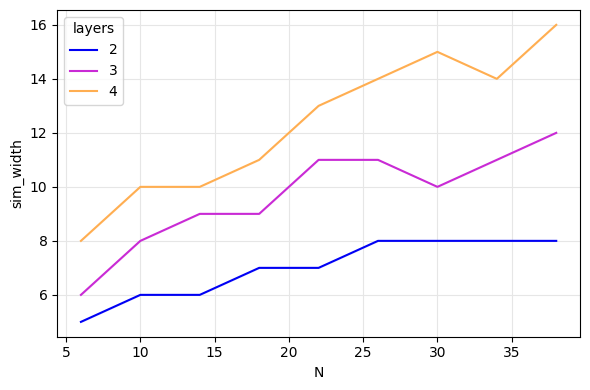

In [55]:
fig = ex.plot_variables('sim_width', layers=[2,3,4], N=range(6, 40, 4), latent_qubits=[0])

In [48]:
width = 26
bytes_in_number = 16
2**width * bytes_in_number/1e9

1.073741824

In [14]:
composer = qtn.CirqBuilder(n_qubits=L)
circ = circuit_11(L, layers, composer)
circ

8
9
20
21


0: ───Y^-0.065───Z^-0.653───X───Y^-0.984───Z^(-6/11)────────────────────────────X─────────────────────────────
                            │                                                   │
1: ───Y^-0.017───Z^0.876────@───Y^0.226────Z^-0.567────X───Y^-0.19───Z^-0.824───@───Y^0.752────Z^0.95─────X───
                                                       │                                                  │
2: ───Y^0.352────Z^(-7/8)───X───Y^-0.902───Z^0.629─────@───Y^0.338───Z^0.798────X───Y^-0.814───Z^-0.488───@───
                            │                                                   │
3: ───Y^0.468────Z^-0.086───@───Y^-0.473───Z^-0.623─────────────────────────────@─────────────────────────────

In [15]:
##This block generates circuit 11

# -- DL
def get_circuit_11(L, layers):
    a=2*pi*np.random.random(layers*(4*L-4))
    q=qiskit.QuantumRegister(L)
    circ=qiskit.QuantumCircuit(q)
    for layer in range(layers):
        for i in range(len(q)):
            ##adds first layer of rotations
            circ.ry(a[layer*(4*L-4)+i],q[i])
            circ.rz(a[layer*(4*L-4)+i+L],q[i])
        #adds first layer of CNOTs
        for j in range(0,len(q),2):
            circ.cx(q[j+1],q[j])
        ##add second layer of rotations
        for k in range(0,len(q)-2):
            circ.ry(a[layer*(4*L-4)+2*L+k],q[k+1])
            circ.rz(a[layer*(4*L-4)+2*L+L-2+k],q[k+1])
            print(layer*(4*L-4)+2*L+k)
        ##add second layer of CNOTs
        for l in range(1,len(q)-1,2):
            circ.cx(q[l+1],q[l])

    return circ

circ = get_circuit_11(L, layers)
circ.draw()

8
9
20
21


┌────────────┐┌────────────┐┌───┐ ┌────────────┐┌────────────┐     »
q1_0: ┤ RY(4.9383) ├┤ RZ(3.9932) ├┤ X ├─┤ RY(0.4938) ├┤ RZ(4.4946) ├─────»
      ├────────────┤├────────────┤└─┬─┘ ├────────────┤├────────────┤┌───┐»
q1_1: ┤ RY(2.4177) ├┤ RZ(6.0502) ├──■───┤ RY(4.3447) ├┤ RZ(1.0627) ├┤ X ├»
      └┬─────────┬─┘├────────────┤┌───┐ ├────────────┤├───────────┬┘└─┬─┘»
q1_2: ─┤ RY(4.8) ├──┤ RZ(5.5554) ├┤ X ├─┤ RY(6.0161) ├┤ RZ(4.632) ├───■──»
      ┌┴─────────┴─┐├────────────┤└─┬─┘┌┴────────────┤├───────────┴┐     »
q1_3: ┤ RY(4.8265) ├┤ RZ(4.8998) ├──■──┤ RY(0.48269) ├┤ RZ(2.8177) ├─────»
      └────────────┘└────────────┘     └─────────────┘└────────────┘     »
«                                   ┌───┐                                 
«q1_0: ─────────────────────────────┤ X ├─────────────────────────────────
«      ┌────────────┐┌─────────────┐└─┬─┘┌────────────┐┌────────────┐┌───┐
«q1_1: ┤ RY(3.8001) ├┤ RZ(0.70145) ├──■──┤ RY(5.7651) ├┤ RZ(2.1107) ├┤ X ├
«      ├────────────┤└┬────────────┤┌───┐├────────────┤├────────────┤└─┬─┘
«q1_2: ┤ RY(1.1727) ├─┤ RZ(5.8497) ├┤ X ├┤ RY(6.0986) ├┤ RZ(6.1857) ├──■──
«      └────────────┘ └────────────┘└─┬─┘└────────────┘└────────────┘     
«q1_3: ───────────────────────────────■───────────────────────────────────
«

In [13]:
##This block generates circuit 12

# -- DL
def get_circuit_12(L):
    a=2*pi*np.random.random(layers*(4*L-4))
    q=qiskit.QuantumRegister(L)
    circ=qiskit.QuantumCircuit(q)
    for layer in range(layers):
        ##adds first layer of rotations
        for i in range(len(q)):
            circ.ry(a[layer*(4*L-4)+i],q[i])
            circ.rz(a[layer*(4*L-4)+i+L],q[i])
        #adds first layer of C-Zs
        for j in range(0,len(q),2):
            circ.cz(q[j+1],q[j])
        ##add second layer of rotations
        for k in range(0,len(q)-2):
            circ.ry(a[layer*(4*L-4)+2*L+k],q[k+1])
            circ.rz(a[layer*(4*L-4)+2*L+L-2+k],q[k+1])
        ##add second layer of C-Zs
        for l in range(1,len(q)-1,2):
            circ.cz(q[l+1],q[l])
    return circ

circ = get_circuit_12(L)
circ.draw()

┌────────────┐┌─────────────┐   ┌──────────────┐ ┌────────────┐   »
q3_0: ┤ RY(1.1448) ├┤ RZ(0.74483) ├─■─┤ RY(0.014114) ├─┤ RZ(5.8723) ├───»
      ├────────────┤└┬───────────┬┘ │ └┬────────────┬┘ ├───────────┬┘   »
q3_1: ┤ RY(2.8722) ├─┤ RZ(1.819) ├──■──┤ RY(4.3083) ├──┤ RZ(2.744) ├──■─»
      ├────────────┤ ├───────────┴┐    ├────────────┤ ┌┴───────────┴┐ │ »
q3_2: ┤ RY(4.7526) ├─┤ RZ(4.6298) ├─■──┤ RY(2.6225) ├─┤ RZ(0.56409) ├─■─»
      ├────────────┤ ├────────────┤ │  ├────────────┤ └┬────────────┤   »
q3_3: ┤ RY(1.7509) ├─┤ RZ(4.5909) ├─■──┤ RY(2.7589) ├──┤ RZ(5.5758) ├───»
      └────────────┘ └────────────┘    └────────────┘  └────────────┘   »
«                                                                    
«q3_0: ─────────────────────────────■────────────────────────────────
«      ┌────────────┐┌────────────┐ │ ┌────────────┐┌────────────┐   
«q3_1: ┤ RY(2.5382) ├┤ RZ(2.9406) ├─■─┤ RY(1.6289) ├┤ RZ(4.6122) ├─■─
«      ├────────────┤├────────────┤   ├───────────┬┘├────────────┤ │ 
«q3_2: ┤ RY(4.5789) ├┤ RZ(2.5972) ├─■─┤ RY(3.405) ├─┤ RZ(1.9172) ├─■─
«      └────────────┘└────────────┘ │ └───────────┘ └────────────┘   
«q3_3: ─────────────────────────────■────────────────────────────────
«

In [16]:
##This block generates circuit 19

# -- DL
def get_circuit_19(L, layers):
    a=2*pi*np.random.random(3*L*layers)
    q = qiskit.QuantumRegister(L)
    circ = qiskit.QuantumCircuit(q)
    for layer in range(layers):
    ##adds first layer of rotations
        for i in range(len(q)):
            circ.rx(a[layer*(3*L)+i],q[i])
            circ.rz(a[layer*(3*L)+i+L],q[i])
        #adds layer of C-Rx
        # crx=CRXGate(np.pi, label=None, ctrl_state=None)
        # -- DL
        crx=CRXGate(np.pi)

        for j in reversed(range(len(q))):
            circ.crx(a[layer*(3*L)+2*L+j],q[j],q[(j+1)%len(q)])
    return circ

circ = get_circuit_19(L, layers)
circ.draw()

┌────────────┐┌────────────┐┌────────────┐                            »
q2_0: ─┤ RX(6.0887) ├┤ RZ(6.2474) ├┤ RX(4.0743) ├────────────────────────────»
      ┌┴────────────┤├────────────┤└─────┬──────┘                            »
q2_1: ┤ RX(0.59058) ├┤ RZ(4.2697) ├──────┼───────────────────────────■───────»
      └┬────────────┤├────────────┤      │                     ┌─────┴──────┐»
q2_2: ─┤ RX(2.3489) ├┤ RZ(1.2146) ├──────┼─────────────■───────┤ RX(5.4206) ├»
       ├────────────┤├────────────┤      │       ┌─────┴──────┐└┬─────────┬─┘»
q2_3: ─┤ RX(4.3803) ├┤ RZ(1.6591) ├──────■───────┤ RX(4.4671) ├─┤ RX(2.3) ├──»
       └────────────┘└────────────┘              └────────────┘ └─────────┘  »
«                     ┌────────────┐ ┌──────────┐ ┌────────────┐              »
«q2_0: ───────■───────┤ RX(4.2234) ├─┤ RZ(2.15) ├─┤ RX(0.4064) ├──────────────»
«       ┌─────┴──────┐├────────────┤┌┴──────────┴┐└─────┬──────┘              »
«q2_1: ─┤ RX(4.6854) ├┤ RX(3.5596) ├┤ RZ(3.4098) ├──────┼─────────────────────»
«      ┌┴────────────┤├────────────┤└────────────┘      │                     »
«q2_2: ┤ RX(0.09427) ├┤ RZ(2.5313) ├────────────────────┼─────────────■───────»
«      └┬────────────┤└────────────┘                    │       ┌─────┴──────┐»
«q2_3: ─┤ RZ(5.4683) ├──────────────────────────────────■───────┤ RX(0.7807) ├»
«       └────────────┘                                          └────────────┘»
«                                  
«q2_0: ────────────────────■───────
«                    ┌─────┴──────┐
«q2_1: ──────■───────┤ RX(6.0679) ├
«      ┌─────┴──────┐└────────────┘
«q2_2: ┤ RX(3.9521) ├──────────────
«      └────────────┘              
«q2_3: ────────────────────────────
«

In [35]:
import qtensor as qt
import qtree
from cartesian_explorer import Explorer

ex = Explorer()

In [72]:
@ex.provider(cache=True)
def qiskit_circ_tw(circ_qasm, ordering_algo='greedy'):
    """
    Returns treewidth of a line graph obtained from 
    qiskit qasm circuit
    
    Args:
        qs_circ_qasm (str): qasm file
    """
    if ordering_algo=='greedy':
        opt = qt.optimisation.Optimizer.OrderingOptimizer()
    elif 'rgreedy' in ordering_algo:
        opt = qt.optimisation.RGreedy(temp=0.02, repeats=10)
    else:
        raise ValueError('Ordering algorithm not supported')
        
    qiskit_circuit = qiskit.QuantumCircuit.from_qasm_str(circ_qasm)
    tn = qt.optimisation.TensorNet.QtreeTensorNet.from_qiskit_circuit(qiskit_circuit)
    opt.optimize(tn)
    return opt.treewidth
    
    
@ex.provider
def circ_qasm(L, circ_type):
    """ Generate autoencoder circuit of a particular type.
    
    I have no idea what a type is -- DL
    
    Args:
        L: size of the circuit
        circ_type (str): type of the circuict
        
    Returns:
        str: qasm of qiskit circuit
    """
    circuit = {
        '19':get_circuit_19,
        '11':get_circuit_11,
        '12':get_circuit_12
           }[circ_type](L)
    return circuit.qasm()

In [73]:
qiskit_circ_tw(circ.qasm())

2

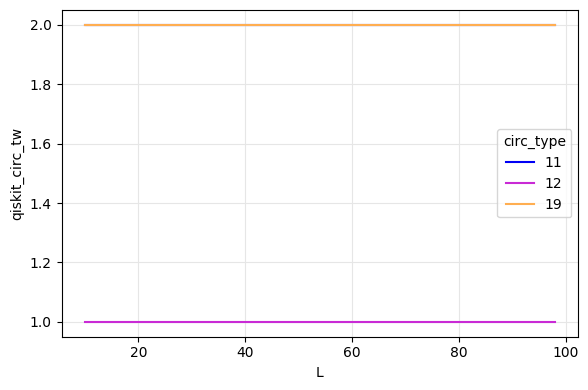

In [74]:
fig = ex.plot_variables('qiskit_circ_tw', circ_type=['11', '12', '19'], L=range(10, 100, 2))